In [1]:
from vizdoom import *
import numpy as np
import pandas as pd

In [2]:
import helpers
from environments import utils
from environments import constants
from helpers import frameutils
from vizdoom.vizdoom import Mode
from vizdoom.vizdoom import ScreenFormat
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, DummyVecEnv
from stable_baselines3 import PPO
import collections

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from config import EnvironmentConfig

env_config = EnvironmentConfig({
    "scenario": "defend_the_center",
    "type": "singleplayer",
    "args": {},
    "vizdoom_mode": "PLAYER",
    "n_parallel": 4,
    "frame_skip": 1,
    "frame_stack": 1,
    "action_combination": False,
    "action_noop": False,
    "obs_width": 320,
    "obs_height": 240,
    "obs_channels": 3,
    "obs_crop": [
      40,
      4,
      0,
      4
    ],
    "obs_resize": [
      0.5,
      0.5
    ]
  })

In [5]:
env = VecTransposeImage(
   VecFrameStack(
        DummyVecEnv([lambda: utils.create_env(env_config, eval=True)]),
        1
    )
)


buttons = env.venv.venv.envs[0].game.get_available_buttons()
buttons = [str(b)[7:] for b in buttons]
buttons = np.array(['ATK', 'TL', 'TR'])
print(buttons)

possible_actions = env.venv.venv.envs[0].possible_actions
print(possible_actions)

env.close()

Built action space of size 3 from buttons [<Button.ATTACK: 0>, <Button.TURN_LEFT: 15>, <Button.TURN_RIGHT: 14>]
['ATK' 'TL' 'TR']
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]


In [6]:
action_names = []

for a in possible_actions:
    active = np.flatnonzero(a)
    action_names.append('+'.join(buttons[active]))
    
action_names

['ATK', 'TL', 'TR']

In [7]:
action_df = pd.DataFrame(possible_actions, columns = buttons)
action_df['action_names'] = action_names
action_df

,ATK,TL,TR,action_names
0,1.00,0.00,0.00,ATK
1,0.00,1.00,0.00,TL
2,0.00,0.00,1.00,TR


In [8]:
model_path = '/home/leandro/ml/rl-doom/trained_agents/defend_the_center/best_model.zip'
model = PPO.load(model_path)

In [9]:
model.policy.to('cpu')

ActorCriticCnnPolicy(
  (features_extractor): CNNFeatureExtractor(
    (cnn): Sequential(
      (0): LayerNorm((3, 100, 156), eps=1e-05, elementwise_affine=True)
      (1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), bias=False)
      (2): LayerNorm((32, 24, 38), eps=1e-05, elementwise_affine=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (5): LayerNorm((64, 11, 18), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.1)
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (8): LayerNorm((64, 9, 16), eps=1e-05, elementwise_affine=True)
      (9): LeakyReLU(negative_slope=0.1)
      (10): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=9216, out_features=128, bias=False)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
  )
  (mlp_extractor): MlpExtr

In [10]:
import torch as th
import time

In [11]:
env = VecTransposeImage(
   VecFrameStack(
        DummyVecEnv([lambda: utils.create_env(env_config, eval=True)]),
        1
    )
)

env.venv.venv.envs[0].game.set_seed(1)
obs = env.reset()
obs = th.as_tensor(obs).float()
done = False
i=0

maxlen=5000
obs_buffer = collections.deque(maxlen=maxlen)
proba_buffer = collections.deque(maxlen=maxlen)
action_buffer = collections.deque(maxlen=maxlen)
value_buffer = collections.deque(maxlen=maxlen)

with th.no_grad():
    while not done:
        i += 1
                
        obs_buffer.append(obs)

        latent_pi, latent_vf, latent_sde = model.policy._get_latent(obs)
        values =  model.policy.value_net(latent_vf)
        distribution = model.policy._get_action_dist_from_latent(latent_pi, latent_sde)
        
        action = distribution.get_actions(deterministic=False).numpy()
                
        proba_buffer.append(distribution.distribution.probs.numpy())
        value_buffer.append(values.item())
        
        obs, rew, done, _ = env.step(action)
        obs = th.as_tensor(obs).float()
        
        time.sleep(0.005)
env.close()

Built action space of size 3 from buttons [<Button.ATTACK: 0>, <Button.TURN_LEFT: 15>, <Button.TURN_RIGHT: 14>]


In [12]:
env.close()

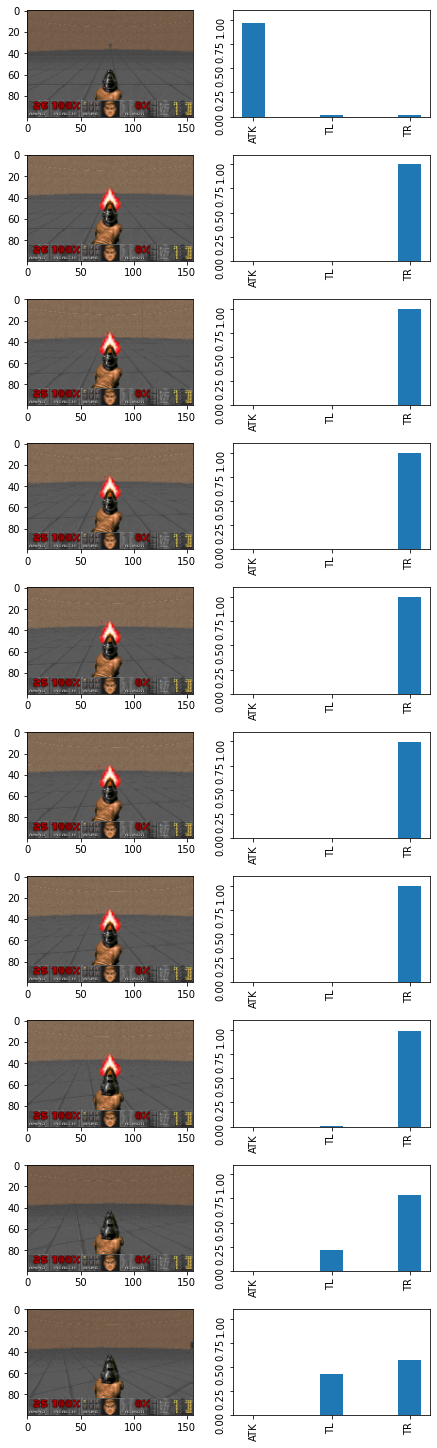

In [13]:
n = 10
img_idx = 10
imrange =list(range(img_idx,img_idx+n))

f = plt.figure(constrained_layout=True, figsize=(6, n * 2))
gs = f.add_gridspec(len(imrange), 2)


for i in range(n):
    idx = img_idx + i
    probas =  proba_buffer[idx][0]
    action_dist = pd.DataFrame(probas, index=action_names).transpose()
    button_dist = np.sum(action_df[buttons] * probas[:,np.newaxis], axis=0).transpose()
    
    
    a1 = f.add_subplot(gs[i, 0])
    a2 = f.add_subplot(gs[i, 1])
    
    a1.imshow(np.rollaxis(obs_buffer[idx][0].numpy()/255.0, 0, 3))
    a2.bar(buttons, button_dist, width=0.3)
    a2.tick_params(rotation=90)
    a2.set_ylim(0,1.1)
    

In [14]:
pb = np.array(proba_buffer).squeeze()

button_activation = []
for i in range(len(proba_buffer)):
    button_activation.append(np.sum(action_df[buttons] * pb[i][:, np.newaxis], axis=0))
    
button_activation = pd.concat(button_activation, axis=1).transpose()
button_activation = button_activation.ewm(alpha=0.7).mean()

button_activation

,ATK,TL,TR
0,0.99,0.01,0.00
1,0.99,0.00,0.00
2,1.00,0.00,0.00
3,1.00,0.00,0.00
4,1.00,0.00,0.00
...,...,...,...
1003,0.75,0.23,0.02
1004,0.77,0.22,0.01
1005,0.77,0.21,0.02
1006,0.77,0.21,0.02


<IPython.core.display.Javascript object>


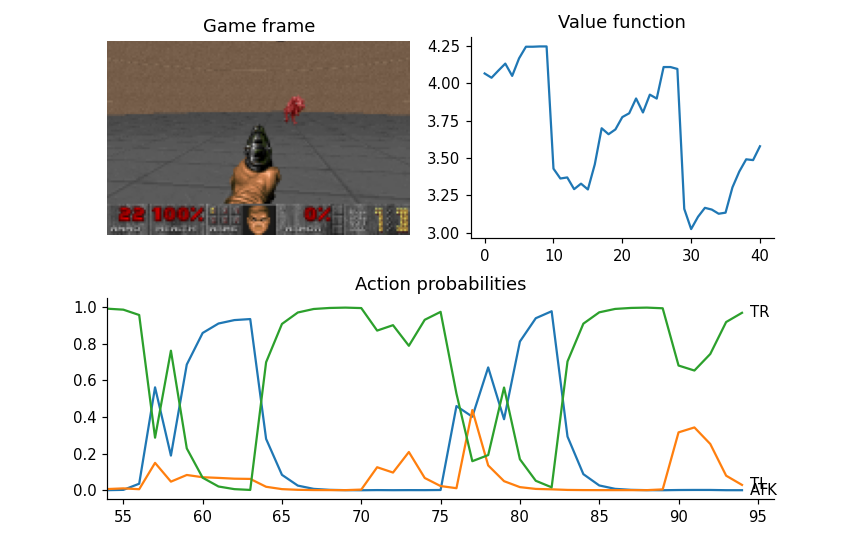

<ipython-input-17-ac218c1fb9db>:48: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(top = 0.93, bottom = 0.07, hspace = 0.3)


In [17]:
%matplotlib notebook

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure with two subplots
f = plt.figure(constrained_layout=True, figsize=(8, 5), dpi=120)
gs = f.add_gridspec(2, 2)

a1 = f.add_subplot(gs[0, 0])
a2 = f.add_subplot(gs[0, 1])
a3 = f.add_subplot(gs[1, :])


# Set titles
a1.set_title('Game frame')
a2.set_title('Value function')
a3.set_title('Action probabilities')

#define the function for use in matplotlib.animation.funcAnimation
def animate(i):
    probas =  proba_buffer[i][0]

    button_dist = np.sum(action_df[buttons] * probas[:,np.newaxis], axis=0).transpose()

    for a in [a1, a2, a3]:
        a.clear()
        a1.set_title('Game frame')
        a2.set_title('Value function')
        a3.set_title('Action probabilities')

    a1.imshow(np.rollaxis(obs_buffer[i][0].numpy()/255.0, 0, 3))
    a1.axis(False)
    a2.plot(np.array(value_buffer)[max(0, i-40): i+1])
    a3.plot(button_activation.iloc[max(0,i-40):i+1])
    
    #a2.set_ylim(-1, 5)
    a3.set_xlim(max(0, i-40), max(i+2,10))
    #a3.legend(buttons, loc='center left', bbox_to_anchor=(-0.2, 0.5))
    a3.spines['top'].set_visible(False)
    a3.spines['right'].set_visible(False)

    a2.spines['top'].set_visible(False)
    a2.spines['right'].set_visible(False)

    plt.subplots_adjust(top = 0.93, bottom = 0.07, hspace = 0.3)

    for j,b in enumerate(buttons):
        a3.text(i+0.5, button_activation.iloc[i, j], b, va='center')
    
ani = animation.FuncAnimation(f, animate, frames=len(obs_buffer), interval=100, repeat=False,  blit=True)

# Set up formatting for the movie files

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

# Save ani
ani.save(r'/home/leandro/Videos/AnimationOutput_slow.mp4', writer=writer)

#plt.show()
